### Executive Summary

A notebook to simulate 1000 DRW light curves,  with 400 points each, spanning length of 2000 days,  with separation of 5 days , and input timescale of 100  days, so that the light curve is well within the unbiased regime ( much longer  than  10 timescales ) . We present the code used to simulate the light curves,  the results of using the code of Chelsea MacLeod to fit these light curves, and the results of fitting them with Celerite. 



### Imports 

In [6]:
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

## Code to simulate light curves 

These light curves were simulated with the following code :

In [ ]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag


def sampling(tau_in = 100, length=10, t_min=1, N_pts = None,  dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    N_pts: if provided , then we choose the dt based on the number 
         of points desired. Otherwise the number of points is 
         calculated based on the desired spacing. 
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        if N_pts is None : 
            t = np.arange(t_min, t_max, dt)
        else : 
            t = np.linspace(t_min, t_max, N_pts)
    else :
        # random sampling with the chosen number of points ... 
        # The output is sorted
        if verbose: 
            print('Using random sampling')
        if N_pts is None : 
            N_pts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, N_pts)) 
        
    return t

# general setup 
regular_sampling = False
yerr =  0.001 # mags 
tau_in = 100 # days 
length = 20 
sigma_in = 0.2 # mags 
SF_inf = sigma_in * np.sqrt(2)
dt = 5.0  # length * tau_in / dt = 400 = N_points 
N_iterations =  1000

# simulating the cadence and DRW sampled at 
# observed times ... 
t = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)


### Using the saved light curves : Chelsea

In [7]:
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_ZI_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-10-31/


"I have attached the fits - the first four columns are:

1. The light curve filename
2. chi^2 of fit
3. log(tau) (in days)
4. log(sigma-hat) (in mag/sqrt(year))

The fit parameters are similar to your input, with: 

$<\tau>$ = 98.5 days 

$<\sigma> = < SF_{\infty} / \sqrt{2} > = 0.2 $ mag


The tau is more biased than sigma, since sigma-hat is well-constrained/not biased, while sigma goes as sqrt(tau).

By the way, the last column list the number of acceptable data points that went into the fit, and sometimes it is <400 because it rejects duplicate MJD values. 
"

In [18]:
# Read in Chelsea results ,  and convert to sigma, tau : 
outDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-10-27/'
fits = Table.read(outDir+'fits.dat', format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau_fit /365.0))  # to convert to mag / sqrt(years)...

In [12]:
# load the results of my old fitting...
test = 'd'
simDir = '../data_products/Fig_Celerite_simulated_LC/2017-07-19/'
setup = np.load(simDir+'DRW_ZI_setup_'+test+'.npy').item()
results = np.load(simDir+'DRW_ZI_results_'+test+'.npy').item()
setup

{'dt': 0.625,
 'length': 20,
 'regular_sampling': False,
 'sigma_bounds': [0.01, 1.0],
 'sigma_in': 0.2,
 'tau_bounds': [1, 10000],
 'tau_in': 100,
 'yerr': 0.001}

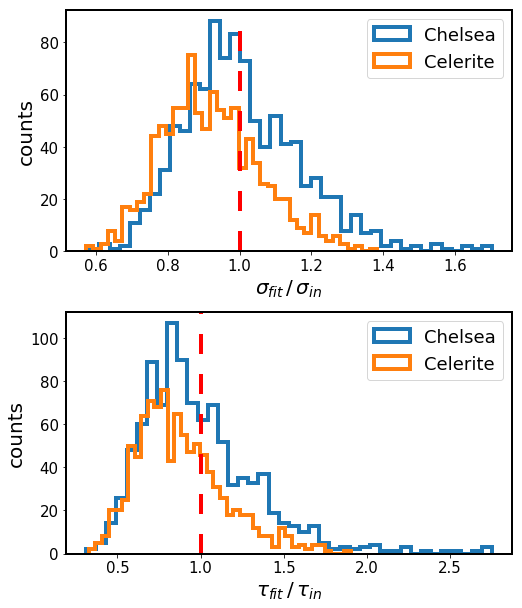

In [19]:
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]

# results of Celerite with ZI light curves 
use_bounds  = True
prior = 'flat'

x =  sigma_fit / sigma_in
ax[0].hist(x, label='Chelsea' , histtype='step', lw=4, bins=40)

x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
ax[0].hist(x, label = 'Celerite', histtype='step', lw=4, bins=40)
    
    
y = tau / tau_in
ax[1].hist(y,  label='Chelsea', histtype='step', lw=4, bins=40)

y = results[use_bounds][prior]['tau_fit'] / tau_in
ax[1].hist(y, label='Celerite', histtype='step', lw=4, bins=40)
    
    
ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_marg.png')
# in each panel , plot histogram of both 

###  Fit saved light curves with Celerite 

In [20]:
# Take exactly the same light curves , and show that Celerite fitting is 
# reproducible, largely to avoid embarassment ... 

print(setup)

# Use only 
# use_bounds  = True
# prior = 'flat'

{'sigma_in': 0.2, 'tau_in': 100, 'sigma_bounds': [0.01, 1.0], 'tau_bounds': [1, 10000], 'yerr': 0.001, 'length': 20, 'dt': 0.625, 'regular_sampling': False}


In [21]:
# Fitting  : each light curve is fit with various settings : 
# [ new_prior,  flat_prior , exp_prior]
#t,y,yerr = lc['time'], lc['mag'], lc['err']

# we have decided to use the bounds since we found 
# having them does not affect much the results  
# and both Kozlowski et al. , and MacLeod's codes
# include some boundaries to avoid nonsensical results ... 
sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]
    
       
# fitting procedure : 
# initialize the Gaussian Process  RealTerm kernel ... 
# it can be done once for all fittings ... 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))

DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)

# initialize dictionaries to store the results  
results = {}
for prior in  ['flat', 'a', 'b']:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float)}

for i in range(len(files)) :
    # print progress... 
    if (i % 100)== 0 : 
        print(i)
        
    # read in Zeljko's light curve 
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']
    
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    initial_params = gp.get_parameter_vector()

    for use_bounds, prior in product([True], ['flat', 'a', 'b']):    
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()

        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'a' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                #log_sigma = log_a / 2.0 
                #log_tau = - log_c
                return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

        if prior is 'b' : 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_sigma = log_a / 2.0 
                log_tau = - log_c
                sigma = np.exp(log_sigma)
                tau  = np.exp(log_tau)
                return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)

        # retrieve the best-fit parameters 
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[prior]['sigma_fit'][i] = sigma_fit
        results[prior]['tau_fit'][i] = tau_fit

# Save the results ...
fname = 'ZI_fits_results_10-30-17.npy'
print('Saving to %s'%(outDir+fname))
np.save(outDir+fname, results)        

0
100
200
300
400
500
600
700
800
900


In [79]:
#files[0]

### Illustration : simulate observations with missing data

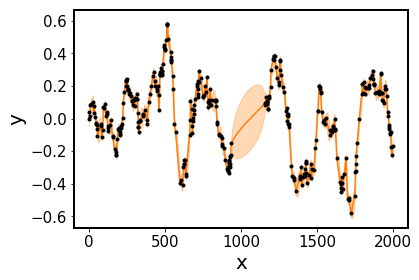

In [107]:
sigma_in = 0.2
tau_in = 100 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))
i=0
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    

start, stop = 200, 250  
# the full observed array has 400 elements. .... 
# we remove some to simulate 'missing data window' ...

t,y,yerr = list(lc['time'][:start])+list(lc['time'][stop:]), \
    list(lc['mag'][:start])+list(lc['mag'][stop:]),\
    list(lc['err'][:start])+list(lc['err'][stop:])

    # call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

initial_params = gp.get_parameter_vector()

sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]


use_bounds = True
prior = 'new'
#for use_bounds, prior in product([True], ['flat', 'exp', 'new']):    
if use_bounds : # use some custom boundaries 
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    bounds = [loga_bounds, logc_bounds]
else : # use the built-in boundaries (-inf : +inf )
    bounds = gp.get_parameter_bounds()

if prior is 'flat' : 
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

if prior is 'exp' :
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        #log_sigma = log_a / 2.0 
        #log_tau = - log_c
        return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

if prior is 'new' : 
    def neg_log_like(params,y,gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        log_sigma = log_a / 2.0 
        log_tau = - log_c
        sigma = np.exp(log_sigma)
        tau  = np.exp(log_tau)
        return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

# do the scipy optimize to find the maximum likelihood estimator 
# for hyperparameters.... 
#print('Using %s prior'%prior)
r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigma_fit = np.exp(res['kernel:log_a']/2)
tau_fit = 1.0 / np.exp(res['kernel:log_c'])

# predict the (Gaussian) conditional (on the observed data) 
# distribution for new observations, to get the 
# estimate for standard deviation 

# where should we evaluate prediction ? 
# a) best at the same points at which we are providing hte 
# simulated dataset ... 
#  x = t

# b) at much denser sampling, so that we'll see that 
# the prediction becomes less certain when there is no
# data ... (note region around 1000...)
x = np.linspace(0, 2000, 5000) # t
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

# plot the prediction vs the observations.... 
color = "#ff7f0e"
#plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")



### Plot the results .... 

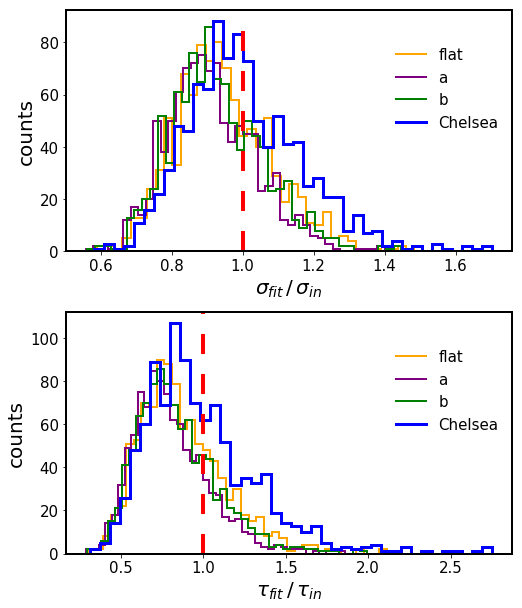

In [73]:
import matplotlib.lines as mlines
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]


# Grab Chelsea' results ...
fits = Table.read(outDir+'fits.dat', format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau_fit/365.0))  # to convert to mag / sqrt(years)...

# Read the results from Celerite ...
simDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-10-27/'
results = np.load(simDir+'ZI_fits_results_10-30-17.npy').item()

# need to store lines for axis legends in an object 
ax_legend_handles = []

color_dict = {'Chelsea':'blue',  'flat':'orange',
             'a':'purple','b':'green' }

# results of Celerite with ZI light curves 
use_bounds  = True
for prior in ['flat','a','b'] : 
    x =  results[prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, histtype='step', lw=2, bins=40, color=color_dict[prior])#
    line = mlines.Line2D([], [], color=color_dict[prior], lw=2, label=prior)
    ax_legend_handles.append(line)
    
    y = results[prior]['tau_fit'] / tau_in
    ax[1].hist(y,  histtype='step', lw=2, bins=40, color=color_dict[prior])
# NOTE :  need to make a line object to 
# avoid getting a legend with a box ... 
# https://matplotlib.org/users/legend_guide.html#plotting-guide-legend 
       
    
# results of Chelsea 
x =  sigma_fit / sigma_in
ax[0].hist(x,  histtype='step', lw=3, bins=40,color=color_dict['Chelsea'])    
line = mlines.Line2D([], [], color=color_dict['Chelsea'], lw=3, label='Chelsea')
ax_legend_handles.append(line)
    
y = tau_fit / tau_in
ax[1].hist(y, histtype='step', lw=3, bins=40,color=color_dict['Chelsea'])

ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')

for i in [0,1]:
    ax[i].legend(loc='upper left', handles = ax_legend_handles, frameon=False,
                bbox_to_anchor=(0.71, 0.9), fontsize=15)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
    
    
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_chelsea_celerite.png')
# in each panel , plot histogram of both 

In [107]:
# Make an AstroPy table from Celerite fit results 
celerite_fits = Table()
celerite_fits['name'] = files
for prior in ['flat','a','b'] : 
    for key in results[prior].keys():
        colname = prior + '-'+key
        celerite_fits[colname] = results[prior][key]
        
# Make an AstroPy table from Chelsea fit results        
fits = Table.read(outDir+'fits.dat', format='ascii')
chelsea_fits = Table()
chelsea_fits['name'] = fits['col1']
chelsea_fits['Chelsea-tau'] = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
chelsea_fits['Chelsea_sigma']  = sigma_hat / np.sqrt(2 / (tau_fit/365.0))
#  to convert to mag / sqrt(years)...

# merge on name 
from astropy.table import join
combined = join(celerite_fits, chelsea_fits)

# save the result ...
combined.write('celerite_chelsea_fit_results.txt', format='ascii')

In [89]:

tau_fit = n

sigma_fit = )  #



col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14
str28,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64
DRWtestCeleriteZI_LC1000.dat,368.747,1.90068,-0.266215,1.73839,2.0966,-0.307763,-0.259736,0,1031.24,495.391,1025.94,0.017332,400
DRWtestCeleriteZI_LC100.dat,362.197,1.93999,-0.271289,1.79161,2.29819,-0.329781,-0.263025,0,1017.31,500.395,1012.78,0.004773,400
DRWtestCeleriteZI_LC101.dat,398.317,1.91188,-0.248677,1.77127,2.15685,-0.292273,-0.25764,0,1014.21,486.914,1008.99,0.037245,400
DRWtestCeleriteZI_LC102.dat,378.353,1.93236,-0.260899,1.77617,2.17711,-0.295594,-0.258547,0,1019.21,483.928,1014.68,-0.002017,400
DRWtestCeleriteZI_LC103.dat,395.105,2.1919,-0.24954,2.07416,3.71531,-0.292341,-0.257756,0,1005.21,375.075,1002.95,-0.046475,399
DRWtestCeleriteZI_LC104.dat,381.574,2.05436,-0.258808,1.9135,2.83782,-0.294628,-0.258357,0,1006.37,436.911,1003.54,0.039266,399
DRWtestCeleriteZI_LC105.dat,404.585,1.92863,-0.246094,1.80173,2.2219,-0.292129,-0.257435,0,1005.55,487.512,1000.89,-0.036205,400
DRWtestCeleriteZI_LC106.dat,416.774,1.9321,-0.237336,1.8148,2.26893,-0.291593,-0.255273,0,993.984,452.713,989.239,0.102741,400
DRWtestCeleriteZI_LC107.dat,403.311,1.9212,-0.246579,1.78895,2.18538,-0.29215,-0.257471,0,1021.42,464.704,1016.28,-0.038847,400


In [82]:
# save combined results : 
# lightcurve#,  Chelsea tau, Chelsea sigma,  no prior tau, no prior sigma, prior a tau, 
# prior a sigma, prior b tau, prior b sigma 

results

{'a': {'sigma_fit': array([ 0.2132833 ,  0.16735055,  0.20631499,  0.17858636,  0.16760988,
          0.18249005,  0.14561735,  0.17800919,  0.19040902,  0.20618303,
          0.17000255,  0.18176325,  0.1874108 ,  0.16270595,  0.22722719,
          0.18129965,  0.15633365,  0.17041494,  0.17057488,  0.20270985,
          0.20408278,  0.18242559,  0.17136463,  0.27229859,  0.21562246,
          0.18349832,  0.20063022,  0.17585088,  0.18979147,  0.19788663,
          0.19844616,  0.22110867,  0.17404421,  0.15549096,  0.19523857,
          0.18616091,  0.20519837,  0.13620728,  0.17372397,  0.21424178,
          0.17362775,  0.18543557,  0.19615507,  0.1843872 ,  0.18123591,
          0.14572372,  0.1859497 ,  0.22456456,  0.19842284,  0.15792091,
          0.18414312,  0.17141003,  0.16939962,  0.1897372 ,  0.20214878,
          0.202332  ,  0.20926152,  0.18138559,  0.17254908,  0.15923978,
          0.17440225,  0.23447663,  0.19086755,  0.14386479,  0.18047758,
          0.21848616

In [74]:
results

{'a': {'sigma_fit': array([ 0.2132833 ,  0.16735055,  0.20631499,  0.17858636,  0.16760988,
          0.18249005,  0.14561735,  0.17800919,  0.19040902,  0.20618303,
          0.17000255,  0.18176325,  0.1874108 ,  0.16270595,  0.22722719,
          0.18129965,  0.15633365,  0.17041494,  0.17057488,  0.20270985,
          0.20408278,  0.18242559,  0.17136463,  0.27229859,  0.21562246,
          0.18349832,  0.20063022,  0.17585088,  0.18979147,  0.19788663,
          0.19844616,  0.22110867,  0.17404421,  0.15549096,  0.19523857,
          0.18616091,  0.20519837,  0.13620728,  0.17372397,  0.21424178,
          0.17362775,  0.18543557,  0.19615507,  0.1843872 ,  0.18123591,
          0.14572372,  0.1859497 ,  0.22456456,  0.19842284,  0.15792091,
          0.18414312,  0.17141003,  0.16939962,  0.1897372 ,  0.20214878,
          0.202332  ,  0.20926152,  0.18138559,  0.17254908,  0.15923978,
          0.17440225,  0.23447663,  0.19086755,  0.14386479,  0.18047758,
          0.21848616